In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('data_set.csv')

In [3]:
df.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


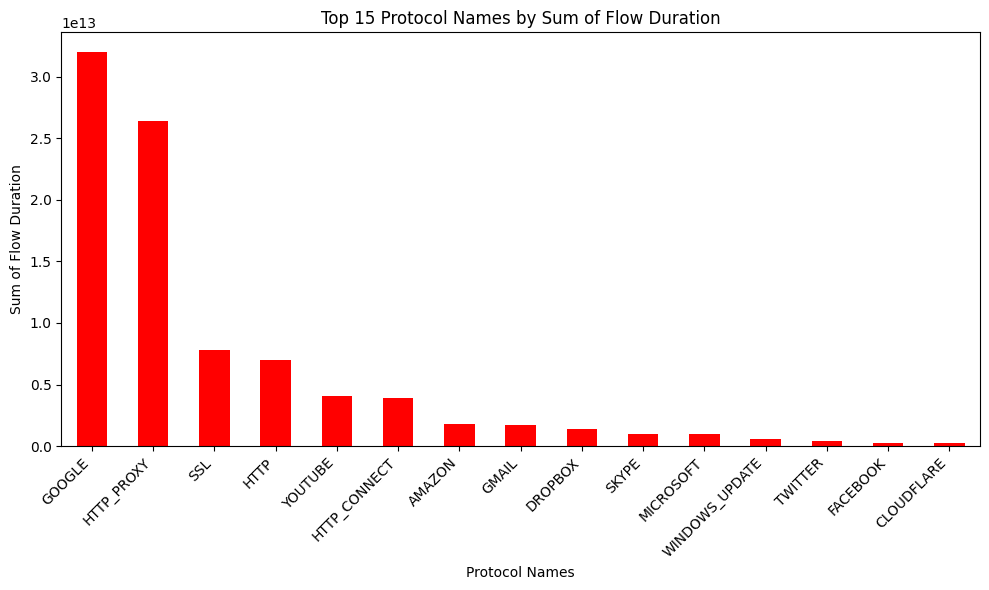

In [4]:
# Here we are trying to aggregate tables grouping protocol names by the sum of flow duration of each protocol
top_protocol_sum_duration = df.groupby('ProtocolName')['Flow.Duration'].sum()

# We have to sort the data by the sum of flow duration in descending order
top_protocol_sum_duration = top_protocol_sum_duration.sort_values(ascending=False)

# And then we selected the top 15 protocols by sum of flow duration
top_apps = top_protocol_sum_duration.head(15)

# Create a bar plot for the sum of flow duration against protocol names
plt.figure(figsize=(10, 6))
top_apps.plot(kind='bar', color='red')
plt.xlabel('Protocol Names')
plt.ylabel('Sum of Flow Duration')
plt.title('Top 15 Protocol Names by Sum of Flow Duration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
top15 = df['ProtocolName'].value_counts().sort_values(ascending=False).head(15).index.tolist()

In [6]:
filtered_df = df[df['ProtocolName'].isin(top15)]

In [7]:
filtered_df.shape, df.shape

((3499879, 87), (3577296, 87))

In [8]:
filtered_df['ProtocolName'].value_counts()

ProtocolName
GOOGLE            959110
HTTP              683734
HTTP_PROXY        623210
SSL               404883
HTTP_CONNECT      317526
YOUTUBE           170781
AMAZON             86875
MICROSOFT          54710
GMAIL              40260
WINDOWS_UPDATE     34471
SKYPE              30657
FACEBOOK           29033
DROPBOX            25102
YAHOO              21268
TWITTER            18259
Name: count, dtype: int64

In [9]:
sampled_data = filtered_df.sample(frac=0.2, random_state=42) 

print("Original dataset shape:", df.shape)
print("Sampled dataset shape:", sampled_data.shape)

Original dataset shape: (3577296, 87)
Sampled dataset shape: (699976, 87)


In [10]:
all_zeros_columns = []

for column in sampled_data:
    if (sampled_data[column] == 0).all():
        all_zeros_columns.append(column)

sampled_data.drop(columns=all_zeros_columns, inplace=True)

In [11]:
sampled_data.shape

(699976, 77)

In [12]:
sampled_data['Time'] = sampled_data['Timestamp'].str[-8:]
sampled_data['Date'] = sampled_data['Timestamp'].str[:10]

In [13]:
non_numeric_columns = sampled_data.select_dtypes(exclude='number').columns.tolist()

print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['Flow.ID', 'Source.IP', 'Destination.IP', 'Timestamp', 'Label', 'ProtocolName', 'Time', 'Date']


In [14]:
sampled_data['DateTime'] = pd.to_datetime(sampled_data['Date'] + ' ' + sampled_data['Time'], format='%d/%m/%Y %H:%M:%S')

# Extract relevant components
sampled_data['Year'] = sampled_data['DateTime'].dt.year
sampled_data['Month'] = sampled_data['DateTime'].dt.month
sampled_data['Day'] = sampled_data['DateTime'].dt.day
sampled_data['Hour'] = sampled_data['DateTime'].dt.hour
sampled_data['Minute'] = sampled_data['DateTime'].dt.minute
sampled_data['Second'] = sampled_data['DateTime'].dt.second

# Encode cyclic features (hour, day of week, etc.) if needed
sampled_data['Hour_sin'] = np.sin(2 * np.pi * sampled_data['Hour'] / 24)
sampled_data['Hour_cos'] = np.cos(2 * np.pi * sampled_data['Hour'] / 24)
# Similar encoding for other cyclical features

# Drop original 'Time' and 'Date' columns
sampled_data.drop(columns=['Time', 'Date'], inplace=True)

# Print the resulting sampled_data
sampled_data.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,ProtocolName,DateTime,Year,Month,Day,Hour,Minute,Second,Hour_sin,Hour_cos
285966,192.168.81.78-10.200.7.4-54664-3128-6,192.168.81.78,54664,10.200.7.4,3128,6,26/04/201703:11:52,4427,2,0,...,HTTP_PROXY,2017-04-26 03:11:52,2017,4,26,3,11,52,0.707107,0.707107
738233,10.200.1.16-10.200.7.196-443-47340-6,10.200.7.196,47340,10.200.1.16,443,6,27/04/201709:51:09,115,1,3,...,SSL,2017-04-27 09:51:09,2017,4,27,9,51,9,0.707107,-0.707107
1115648,192.168.90.8-10.200.7.6-50863-3128-6,192.168.90.8,50863,10.200.7.6,3128,6,27/04/201711:26:18,326204,7,5,...,MICROSOFT,2017-04-27 11:26:18,2017,4,27,11,26,18,0.258819,-0.965926
1469680,192.168.10.65-10.200.7.6-60825-3128-6,192.168.10.65,60825,10.200.7.6,3128,6,27/04/201705:55:33,2384150,8,6,...,HTTP,2017-04-27 05:55:33,2017,4,27,5,55,33,0.965926,0.258819
1060504,172.17.1.200-10.200.7.9-49593-3128-6,10.200.7.9,3128,172.17.1.200,49593,6,27/04/201711:30:37,255,2,0,...,HTTP,2017-04-27 11:30:37,2017,4,27,11,30,37,0.258819,-0.965926


In [15]:
non_numeric_columns = sampled_data.select_dtypes(exclude='number').columns.tolist()

print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['Flow.ID', 'Source.IP', 'Destination.IP', 'Timestamp', 'Label', 'ProtocolName', 'DateTime']


In [16]:

import ipaddress

sampled_data['Source_IP'] = sampled_data['Source.IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))
sampled_data['Destination_IP'] = sampled_data['Destination.IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))

# Convert Source Port and Destination Port columns to integers (assuming they are represented as strings)
# Drop the original columns
sampled_data.drop(columns=['Source.IP', 'Destination.IP','Timestamp'], inplace=True)

# Print the resulting dataset
sampled_data.head()

,Flow.ID,Source.Port,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,...,Year,Month,Day,Hour,Minute,Second,Hour_sin,Hour_cos,Source_IP,Destination_IP
285966,192.168.81.78-10.200.7.4-54664-3128-6,54664,3128,6,4427,2,0,0,0.0,0,...,2017,4,26,3,11,52,0.707107,0.707107,3232256334,180881156
738233,10.200.1.16-10.200.7.196-443-47340-6,47340,443,6,115,1,3,0,0.0,0,...,2017,4,27,9,51,9,0.707107,-0.707107,180881348,180879632
1115648,192.168.90.8-10.200.7.6-50863-3128-6,50863,3128,6,326204,7,5,388,110.0,141,...,2017,4,27,11,26,18,0.258819,-0.965926,3232258568,180881158
1469680,192.168.10.65-10.200.7.6-60825-3128-6,60825,3128,6,2384150,8,6,8854,2116.0,4307,...,2017,4,27,5,55,33,0.965926,0.258819,3232238145,180881158
1060504,172.17.1.200-10.200.7.9-49593-3128-6,3128,49593,6,255,2,0,69,0.0,63,...,2017,4,27,11,30,37,0.258819,-0.965926,180881161,2886795720


In [17]:
non_numeric_columns = sampled_data.select_dtypes(exclude='number').columns.tolist()

print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['Flow.ID', 'Label', 'ProtocolName', 'DateTime']


In [18]:
import pandas as pd

duplicated_columns = []

# Iterate through each column
for i, column in enumerate(sampled_data.columns):
    # Compare it with every other column
    for j in range(i + 1, len(sampled_data.columns)):
        # If the values in the two columns are identical, they are duplicates
        if sampled_data[column].equals(sampled_data.iloc[:, j]):
            duplicated_columns.append(sampled_data.columns[j])

# Drop the duplicated columns
sampled_data = sampled_data.drop(columns=duplicated_columns)

# Print a message indicating which columns were dropped
print("Dropped columns:", duplicated_columns)


Dropped columns: ['Subflow.Fwd.Packets', 'Subflow.Bwd.Packets', 'Subflow.Fwd.Bytes', 'SYN.Flag.Count', 'Fwd.Header.Length.1']


In [19]:
sampled_data.drop(columns=['Flow.ID', 'Label','DateTime'], inplace=True)

In [20]:
sampled_data.shape

(699976, 77)

In [21]:
non_numeric_columns = sampled_data.select_dtypes(exclude='number').columns.tolist()

print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['ProtocolName']


In [22]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Get the data types of all columns
data_types = sampled_data.dtypes

# Filter columns with object or categorical dtype
categorical_columns = data_types[data_types == 'object'].index.tolist()

# Alternatively, you can also check for categorical dtype
categorical_columns += data_types[data_types == 'category'].index.tolist()

# Print the list of categorical columns
print("Categorical columns:", categorical_columns)


Categorical columns: ['ProtocolName']


In [23]:
summary_stats = sampled_data.describe()

# Identify numerical columns with a large range of values (e.g., standard deviation)
columns_to_scale = summary_stats.columns[(summary_stats.loc['std'] > 1.0) | (summary_stats.loc['std'] < -1.0)].tolist()

print("Columns needing feature scaling:")
print(columns_to_scale)

Columns needing feature scaling:
['Source.Port', 'Destination.Port', 'Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets', 'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min', 'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std', 'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min', 'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std', 'Flow.Bytes.s', 'Flow.Packets.s', 'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std', 'Fwd.IAT.Max', 'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean', 'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.Header.Length', 'Bwd.Header.Length', 'Fwd.Packets.s', 'Bwd.Packets.s', 'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean', 'Packet.Length.Std', 'Packet.Length.Variance', 'Down.Up.Ratio', 'Average.Packet.Size', 'Avg.Fwd.Segment.Size', 'Avg.Bwd.Segment.Size', 'Subflow.Bwd.Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Standardization (Z-score normalization)
standard_scaler = StandardScaler()
sampled_data_standard_scaled = sampled_data.copy()  # Make a copy of the DataFrame
sampled_data_standard_scaled[columns_to_scale] = standard_scaler.fit_transform(sampled_data_standard_scaled[columns_to_scale])


In [25]:
sampled_data_standard_scaled.shape

(699976, 77)

In [27]:
from sklearn.model_selection import train_test_split

# Assuming 'sampled_data_encoded' is your DataFrame with the target variable (protocol names) encoded

# Split the data into features (X) and the encoded target variable (y)
X = sampled_data_standard_scaled.drop(columns=['ProtocolName'])
y = sampled_data_standard_scaled['ProtocolName']

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Now, you have X_train, X_test, y_train, and y_test for model training and evaluation


In [28]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((419985, 76), (139996, 76), (139995, 76), (419985,), (139996,), (139995,))

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize and fit models
#logistic_regression = LogisticRegression()
#logistic_regression.fit(X_train, y_train)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)



#svm = SVC()
#svm.fit(X_train, y_train)

# Make predictions
#lr_predictions = logistic_regression.predict(X_test)
rf_predictions = random_forest.predict(X_test)
#gb_predictions = gradient_boosting.predict(X_test)
#svm_predictions = svm.predict(X_test)

# Evaluate models
#print("Logistic Regression:")
#print(classification_report(y_test, lr_predictions))
#print("Accuracy:", accuracy_score(y_test, lr_predictions))

print("Random Forest:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))




Random Forest:
                precision    recall  f1-score   support

        AMAZON       0.98      0.97      0.97      3474
       DROPBOX       0.99      0.91      0.95      1017
      FACEBOOK       0.97      0.92      0.95      1173
         GMAIL       0.95      0.83      0.89      1666
        GOOGLE       0.98      1.00      0.99     38573
          HTTP       1.00      1.00      1.00     27234
  HTTP_CONNECT       1.00      1.00      1.00     12739
    HTTP_PROXY       0.99      1.00      0.99     24785
     MICROSOFT       0.98      0.94      0.96      2165
         SKYPE       0.96      0.83      0.89      1249
           SSL       0.99      1.00      0.99     16146
       TWITTER       0.93      0.65      0.77       750
WINDOWS_UPDATE       0.98      0.94      0.96      1398
         YAHOO       0.94      0.73      0.82       829
       YOUTUBE       0.94      0.97      0.96      6798

      accuracy                           0.99    139996
     macro avg       0.97      

In [32]:
y_val_pred = random_forest.predict(X_val)

classification_rep = classification_report(y_val, y_val_pred)

print("Classification Report for Validation Set:")
print(classification_rep)

Classification Report for Validation Set:
                precision    recall  f1-score   support

        AMAZON       0.99      0.96      0.97      3389
       DROPBOX       0.99      0.92      0.95      1056
      FACEBOOK       0.98      0.92      0.95      1168
         GMAIL       0.94      0.83      0.88      1578
        GOOGLE       0.98      1.00      0.99     38515
          HTTP       1.00      1.00      1.00     27355
  HTTP_CONNECT       1.00      1.00      1.00     12679
    HTTP_PROXY       0.99      1.00      0.99     25033
     MICROSOFT       0.98      0.92      0.95      2110
         SKYPE       0.96      0.83      0.89      1180
           SSL       0.99      1.00      0.99     16231
       TWITTER       0.93      0.64      0.76       715
WINDOWS_UPDATE       0.98      0.93      0.96      1383
         YAHOO       0.96      0.71      0.82       806
       YOUTUBE       0.94      0.97      0.96      6797

      accuracy                           0.99    139995
    

In [33]:
logistic_regression = LogisticRegression(max_iter=5000)
logistic_regression.fit(X_train, y_train)
lr_predictions = logistic_regression.predict(X_test)
print(classification_report(y_test, lr_predictions))
print("Accuracy:", accuracy_score(y_test, lr_predictions))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metr

                precision    recall  f1-score   support

        AMAZON       0.85      0.83      0.84      3474
       DROPBOX       0.91      0.48      0.63      1017
      FACEBOOK       0.80      0.11      0.19      1173
         GMAIL       0.00      0.00      0.00      1666
        GOOGLE       0.64      0.80      0.71     38573
          HTTP       1.00      1.00      1.00     27234
  HTTP_CONNECT       0.44      0.41      0.42     12739
    HTTP_PROXY       0.63      0.71      0.67     24785
     MICROSOFT       0.93      0.80      0.86      2165
         SKYPE       0.56      0.02      0.04      1249
           SSL       0.92      0.96      0.94     16146
       TWITTER       0.00      0.00      0.00       750
WINDOWS_UPDATE       0.72      0.20      0.31      1398
         YAHOO       0.00      0.00      0.00       829
       YOUTUBE       0.62      0.13      0.22      6798

      accuracy                           0.73    139996
     macro avg       0.60      0.43      0.46 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
y_val_pred = logistic_regression.predict(X_val)

classification_rep = classification_report(y_val, y_val_pred)

print("Classification Report for Validation Set:")
print(classification_rep)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Validation Set:
                precision    recall  f1-score   support

        AMAZON       0.84      0.82      0.83      3389
       DROPBOX       0.91      0.48      0.63      1056
      FACEBOOK       0.86      0.12      0.21      1168
         GMAIL       0.12      0.00      0.00      1578
        GOOGLE       0.65      0.80      0.72     38515
          HTTP       1.00      1.00      1.00     27355
  HTTP_CONNECT       0.44      0.41      0.42     12679
    HTTP_PROXY       0.63      0.71      0.67     25033
     MICROSOFT       0.93      0.78      0.84      2110
         SKYPE       0.51      0.02      0.04      1180
           SSL       0.93      0.97      0.95     16231
       TWITTER       0.00      0.00      0.00       715
WINDOWS_UPDATE       0.71      0.19      0.29      1383
         YAHOO       0.00      0.00      0.00       806
       YOUTUBE       0.64      0.14      0.22      6797

      accuracy                           0.74    139995
    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
for i, column in enumerate(sampled_data.columns):
    # Compare it with every other column
    for j in range(i + 1, len(sampled_data.columns)):
        # If the values in the two columns are identical, they are duplicates
        if sampled_data[column].equals(sampled_data.iloc[:, j]):
            duplicated_columns.append(sampled_data.columns[j])

# Drop the duplicated columns
sampled_data = sampled_data.drop(columns=duplicated_columns)

# Print a message indicating which columns were dropped
print("Dropped columns:", duplicated_columns)

In [35]:
import pickle
pickle.dump(sampled_data_standard_scaled,open('preprocessed_data.pickle',mode = 'wb'))